## Name entity recognition 

# Author: Hok Seng

<p>
    <b>Notebook Sections</b><br>
    This notebook is divided into the following sections:
    <ul>
        <li>A. Setting Environment</li>
        <li>B. Set the Devic (cpu or mps) </li>
    </ul>
</p>

In [1]:
import os
import subprocess
import requests

os.getcwd()

'/Users/senghok/Documents/Internship 2A/code'

## Download necessary packages

In [ ]:
# with open("requirement.txt", "r") as file:
#     for f in file.readlines():
#         package = f.strip()
#         if package:
#             subprocess.check_call(["pip", "install", package])
#             %pip install {package}

## Import necessary packages

In [1]:


# save_dir = "data"
# os.makedirs(save_dir,exist_ok = True)

# file_name = os.path.join(save_dir,"NER_dataset.csv")

# response = requests.get(url,stream = True)


# if response.status_code == 200:
#     with open(file_name,"wb") as file:
#         for chunk in response.iter_content(chunk_size=1024):
#             file.write(chunk)
#     print(f"File downloaded successfully and saved to {file_name}")
# else:
#     print(f"Failed to download file. Status code: {response.status_code}")



NameError: name 'os' is not defined

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
import seaborn as sns
import collections
from itertools import chain
import random
import copy
import itertools
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from transformers import BertForTokenClassification
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns



# set the option to display all columns
pd.set_option('display.max_columns', None)

/Users/senghok/Documents/Internship 2A/code/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/senghok/Documents/Internship 2A/code/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.l

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense


### Import clean data

In [3]:
train_df = pd.read_csv('./data/train.csv')
valid_df = pd.read_csv('./data/valid.csv')
test_df = pd.read_csv('./data/test.csv')

In [4]:

print(f"Train Dataset size: {len(train_df)}")
print(f"Valid Data Size: {len(valid_df)}")

Train Dataset size: 34279
Valid Data Size: 3808


In [5]:

print("TRAIN Dataset: {}".format(train_df.shape))
print("VALID Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

TRAIN Dataset: (34279, 2)
VALID Dataset: (3808, 2)
TEST Dataset: (9520, 2)


In [6]:
train_df.head()

,sentence,labels
0,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
1,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,The party is divided over Britain 's participa...,"O,O,O,O,O,B-gpe,O,O,O,O,B-geo,O,O,O,O,O,O,O,B-..."
3,Two Germans and four Nigerian oil workers were...,"O,B-gpe,O,O,B-gpe,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,The German firm works as a sub-contractor for ...,"O,B-gpe,O,O,O,O,O,O,B-org,O"


In [7]:
train_df["labels"].iloc[3]

'O,B-gpe,O,O,B-gpe,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,O,B-geo,O,O'

In [8]:
train_df["sentence"].iloc[3]

"Two Germans and four Nigerian oil workers were kidnapped by armed militants during a raid on a boat in Nigeria 's southern oil-rich Delta region ."

In [9]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [10]:
train_df.head(3)

,sentence,labels
0,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
1,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,The party is divided over Britain 's participa...,"O,O,O,O,O,B-gpe,O,O,O,O,B-geo,O,O,O,O,O,O,O,B-..."


In [11]:
all_labels = train_df['labels'].apply(lambda x: x.split(','))
all_labels = sorted(set(label for labels in all_labels for label in labels ))
all_labels

['B-geo',
 'B-gpe',
 'B-org',
 'B-per',
 'B-tim',
 'I-geo',
 'I-org',
 'I-per',
 'I-tim',
 'O']

### One hot encoding for all the labels in training , validation and testing dataset

In [12]:

# Step 2: Initialize the MultiLabelBinarizer with all known classes
mlb = MultiLabelBinarizer(classes=sorted(all_labels))
# Step 3: Transform per-sentence label sets
unique_train_labels_ohe = mlb.fit_transform(
    train_df['labels'].apply(lambda x: set(x.split(',')))
)

In [13]:
unique_train_labels_ohe.shape

(34279, 10)

In [14]:


# Validation
unique_valid_labels_ohe = mlb.transform(
    valid_df['labels'].apply(lambda x: set(x.split(',')))
)

# Testing
unique_test_labels_ohe = mlb.transform(
    test_df['labels'].apply(lambda x: set(x.split(',')))
)


In [15]:
# compute number of samples
num_train_samples = unique_train_labels_ohe.shape[0]
num_valid_samples = unique_valid_labels_ohe.shape[0]
num_test_samples = unique_test_labels_ohe.shape[0]

# compute number of samples for each unique label
train_labels_count = unique_train_labels_ohe.sum(axis=0)
valid_labels_count = unique_valid_labels_ohe.sum(axis=0)
test_labels_count = unique_test_labels_ohe.sum(axis=0)

# compute proportion of samples for each unique label
prop_train_labels = train_labels_count/num_train_samples
prop_valid_labels = valid_labels_count/num_valid_samples
prop_test_labels = test_labels_count/num_test_samples


print("Training Data")
print("==============")
print(f"Total num of training samples: {num_train_samples}")
print(f"Total num of each label: {train_labels_count}")
print(f"Proportions of each label: {prop_train_labels}\n")

print("Validation Data")
print("==============")
print(f"Total num of validation samples: {num_valid_samples}")
print(f"Total num of each label: {valid_labels_count}")
print(f"Proportions of each label: {prop_valid_labels}\n")

print("Testing Data")
print("===============")
print(f"Total num of training samples: {num_test_samples}")
print(f"Total num of each label: {test_labels_count}")
print(f"Proportions of each label: {prop_test_labels}")

Training Data
Total num of training samples: 34279
Total num of each label: [17483  9207 11288  9674 12369  4313  6120  7614  3090 34273]
Proportions of each label: [0.51002071 0.2685901  0.32929782 0.2822136  0.36083316 0.12582047
 0.17853496 0.2221185  0.09014265 0.99982497]

Validation Data
Total num of validation samples: 3808
Total num of each label: [1943 1023 1254 1074 1374  492  646  855  308 3808]
Proportions of each label: [0.5102416  0.26864496 0.32930672 0.28203782 0.36081933 0.12920168
 0.16964286 0.22452731 0.08088235 1.        ]

Testing Data
Total num of training samples: 9520
Total num of each label: [4857 2558 3135 2685 3436 1210 1683 2124  834 9520]
Proportions of each label: [0.51018908 0.26869748 0.32930672 0.28203782 0.36092437 0.12710084
 0.17678571 0.22310924 0.08760504 1.        ]


### Create the proportion dataFrame for training, validation and testing data

In [16]:
label2id = {k:v+1 for v,k in enumerate(all_labels)}
id2label = {k+1:v for k,v in enumerate(all_labels)}

In [17]:
# create dict for proportions of each label
prop_data = {
    'labels' : list(label2id.keys()),
    'train' : prop_train_labels,
    'valid' : prop_valid_labels,
    'test' : prop_test_labels
}


prop_df = pd.DataFrame.from_dict(prop_data)


display(prop_df)

,labels,train,valid,test
0,B-geo,0.510021,0.510242,0.510189
1,B-gpe,0.268590,0.268645,0.268697
2,B-org,0.329298,0.329307,0.329307
3,B-per,0.282214,0.282038,0.282038
4,B-tim,0.360833,0.360819,0.360924
5,I-geo,0.125820,0.129202,0.127101
6,I-org,0.178535,0.169643,0.176786
7,I-per,0.222118,0.224527,0.223109
8,I-tim,0.090143,0.080882,0.087605
9,O,0.999825,1.000000,1.000000


In [18]:
# fig, ax = plt.subplots(figsize=(10, 8))
# g = sns.barplot(
#     data=prop_df.melt(id_vars = ["labels"], value_vars=["train", "valid", "test"]),
#     y="value", x="v
# 
# 
# 
# ariable", hue="labels", errorbar=None
# )

# # for legend text
# plt.setp(g.get_legend().get_texts(), fontsize='10')  
 
# # for legend title
# plt.setp(g.get_legend().get_title(), fontsize='10')
# plt.title("Proportions of sentences containing each label - training, validation and testing dataset")
# plt.savefig('./images/label_proportions.png', bbox_inches='tight', dpi=300)
# plt.show()

### Check distributions of 2nd order

In [19]:
# from collections import Counter
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

# label_combination_df = pd.DataFrame({
#     'train': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_train_labels_ohe, order=2) for combination in row),
#     'valid': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_valid_labels_ohe, order=2) for combination in row),
#     'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(unique_test_labels_ohe, order=2) for combination in row),
# }).T.fillna(0.0).astype('float')

# # compute proportions
# label_combination_df.loc['train'] = label_combination_df.loc['train']/num_train_samples
# label_combination_df.loc['valid'] = label_combination_df.loc['valid']/num_valid_samples
# label_combination_df.loc['test'] = label_combination_df.loc['test']/num_test_samples

# label_combination_df

In [20]:
# from collections import Counter
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

# label_combination_df = pd.DataFrame({
#     'train': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_train_labels_ohe, order=3) for combination in row),
#     'valid': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_valid_labels_ohe, order=3) for combination in row),
#     'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(unique_test_labels_ohe, order=3) for combination in row),
# }).T.fillna(0.0).astype('float')

# # compute proportions
# label_combination_df.loc['train'] = label_combination_df.loc['train']/num_train_samples
# label_combination_df.loc['valid'] = label_combination_df.loc['valid']/num_valid_samples
# label_combination_df.loc['test'] = label_combination_df.loc['test']/num_test_samples

# label_combination_df

### Baseline model
### RNN + Softmax

### Tokenization
There are many tokenization methods  including:
<li>
Bert Tokenizer 
</li>
<li>
Byte-Pair Encoding (BPE) - Robust to unknown words
</li>

### Word tokenization

In [21]:
# Tokenize sentences (whitespace)
def tokenize(sentence):
    return sentence.strip().split()
# Split labels
def split_labels(label_str):
    return label_str.strip().split(',')


In [22]:

train_df['tokens'] = train_df['sentence'].apply(tokenize)
train_df['label_list'] = train_df['labels'].apply(split_labels)

In [23]:
train_df[train_df["tokens"].apply(len) >50]



,sentence,labels,tokens,label_list
600,The visit by Assistant Secretary of State for ...,"O,O,O,O,O,O,B-org,I-org,I-org,I-org,I-org,I-or...","[The, visit, by, Assistant, Secretary, of, Sta...","[O, O, O, O, O, O, B-org, I-org, I-org, I-org,..."
635,Strong performances in construction and manufa...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,...","[Strong, performances, in, construction, and, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
803,After failing in the Korean War ( 1950 - 53 ) ...,"O,O,O,O,O,O,O,B-tim,I-tim,I-tim,O,O,O,O,B-geo,...","[After, failing, in, the, Korean, War, (, 1950...","[O, O, O, O, O, O, O, B-tim, I-tim, I-tim, O, ..."
1140,"Former U.S. Marine General John J. "" Jack "" Sh...","O,B-org,I-org,I-org,B-per,I-per,I-per,I-per,I-...","[Former, U.S., Marine, General, John, J., "", J...","[O, B-org, I-org, I-org, B-per, I-per, I-per, ..."
4348,But the Honest Man explained that as he was me...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,...","[But, the, Honest, Man, explained, that, as, h...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...
30696,Mourners and officials of the Socialist Party ...,"O,O,O,O,O,B-org,I-org,O,O,B-per,O,O,O,O,O,O,O,...","[Mourners, and, officials, of, the, Socialist,...","[O, O, O, O, O, B-org, I-org, O, O, B-per, O, ..."
30796,In an interview broadcast Sunday on U.S. telev...,"O,O,O,O,B-tim,O,B-geo,O,O,O,B-org,O,O,O,O,O,B-...","[In, an, interview, broadcast, Sunday, on, U.S...","[O, O, O, O, B-tim, O, B-geo, O, O, O, B-org, ..."
32287,Following its heyday as a global maritime powe...,"O,O,O,O,O,O,O,O,O,O,B-tim,I-tim,I-tim,O,O,B-pe...","[Following, its, heyday, as, a, global, mariti...","[O, O, O, O, O, O, O, O, O, O, B-tim, I-tim, I..."
32874,"Renewed activity in the mining sector , the so...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,O,O,O,...","[Renewed, activity, in, the, mining, sector, ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


### ID tokenization

### We can use Text vectorization

# Text vectorization consiste of parts:
<li>
    Standardization
</li>
<li>
    Tokenization
</li>
<li>
    Vocabulary building
</li>

### Vocabulary

### Necessary dictionaries for encoding and decoding phase

In [24]:

label2id = {k:v+1 for v,k in enumerate(all_labels)}
id2label = {k+1:v for k,v in enumerate(all_labels)}

In [25]:
label2id["<PAD>"] = 0

In [26]:
label2id

{'B-geo': 1,
 'B-gpe': 2,
 'B-org': 3,
 'B-per': 4,
 'B-tim': 5,
 'I-geo': 6,
 'I-org': 7,
 'I-per': 8,
 'I-tim': 9,
 'O': 10,
 '<PAD>': 0}

In [27]:
word_counts = Counter(word for tokens in train_df['tokens'] for word in tokens)
word2id = {word: i + 2 for i, word in enumerate(word_counts)} # turn words into unique ids (+2) because give 0,1 to UNK and PAD

In [28]:
id2word = {i+2:word for i,word in enumerate(word_counts)}


In [29]:
word2id  ## vocabulary

{'Families': 2,
 'of': 3,
 'soldiers': 4,
 'killed': 5,
 'in': 6,
 'the': 7,
 'conflict': 8,
 'joined': 9,
 'protesters': 10,
 'who': 11,
 'carried': 12,
 'banners': 13,
 'with': 14,
 'such': 15,
 'slogans': 16,
 'as': 17,
 '"': 18,
 'Bush': 19,
 'Number': 20,
 'One': 21,
 'Terrorist': 22,
 'and': 23,
 'Stop': 24,
 'Bombings': 25,
 '.': 26,
 'Police': 27,
 'put': 28,
 'number': 29,
 'marchers': 30,
 'at': 31,
 '10,000': 32,
 'while': 33,
 'organizers': 34,
 'claimed': 35,
 'it': 36,
 'was': 37,
 '1,00,000': 38,
 'The': 39,
 'party': 40,
 'is': 41,
 'divided': 42,
 'over': 43,
 'Britain': 44,
 "'s": 45,
 'participation': 46,
 'Iraq': 47,
 'continued': 48,
 'deployment': 49,
 '8,500': 50,
 'British': 51,
 'troops': 52,
 'that': 53,
 'country': 54,
 'Two': 55,
 'Germans': 56,
 'four': 57,
 'Nigerian': 58,
 'oil': 59,
 'workers': 60,
 'were': 61,
 'kidnapped': 62,
 'by': 63,
 'armed': 64,
 'militants': 65,
 'during': 66,
 'a': 67,
 'raid': 68,
 'on': 69,
 'boat': 70,
 'Nigeria': 71,
 'sout

### Add '<PAD>' to use when padding and '<UNK>' in the case where there are unknown entities

In [30]:
word2id['<PAD>'] = 0
word2id['<UNK>'] = 1

In [31]:
word2id['<UNK>']

1

In [32]:
word2id['<PAD>'], word2id['<UNK>']

(0, 1)

In [33]:
fallback = '<UNK>'
fallback_id = word2id.get('B-gpe', list(label2id.values())[0])  ## get idea of a word

fallback_id

1

In [34]:
pad_token = '<PAD>'
pad_id = label2id.get(pad_token, list(label2id.values())[0])  
pad_id

0

In [35]:
fallback_id = label2id.get('O', list(label2id.values())[0])
fallback_id

10

In [36]:
MAX_LEN = 40

def encode(tokens, vocab, pad_len=40, fallback='<UNK>', pad_token='<PAD>'):
    """
    Encodes a list of tokens using a vocabulary.

    - tokens: List[str] → tokens or labels (e.g., words or NER tags)
    - vocab: dict → maps token to index
    - pad_len: int → fixed output length (pad or truncate)
    - fallback: str → token to use if one isn't found (only relevant for input)
    - pad_token: str → token to use for padding

    Returns: List[int] of length `pad_len`
    """
    fallback_id = vocab.get(fallback, 0)     # Use <UNK> if token not found
    pad_id = vocab.get(pad_token, 0)         # Use <PAD> for padding

    # Map each token to its ID
    ids = [vocab.get(tok, fallback_id) for tok in tokens]

    # Truncate or pad to fixed length
    if len(ids) > pad_len:
        return ids[:pad_len]
    else:
        return ids + [pad_id] * (pad_len - len(ids))


In [37]:
X = np.array([encode(tokens, word2id, fallback='<UNK>', pad_token='<PAD>') for tokens in train_df['tokens']])
y = np.array([encode(labels, label2id, fallback='O', pad_token= '<PAD>') for labels in train_df['label_list']])
vocab_size = len(word2id)
label_size = len(label2id)


In [38]:
## Example:
sentence = train_df['tokens'][2]   
label    = train_df['label_list'][2]
encoded_sentence = encode(sentence,word2id,fallback= '<UNK>', pad_token = '<PAD>')
encoded_label  = encode(label, label2id, fallback = 'O', pad_token = '<PAD>')
print(f"Sentence : {sentence} with length {len(sentence)}\n",
       f"encoded sentence : {encoded_sentence} with length {len(encoded_sentence)}\n")

print(f"Label : {label} with length {len(label)}\n",
       f"encoded label : {encoded_label} with length {len(encoded_label)}")

Sentence : ['The', 'party', 'is', 'divided', 'over', 'Britain', "'s", 'participation', 'in', 'the', 'Iraq', 'conflict', 'and', 'the', 'continued', 'deployment', 'of', '8,500', 'British', 'troops', 'in', 'that', 'country', '.'] with length 24
 encoded sentence : [39, 40, 41, 42, 43, 44, 45, 46, 6, 7, 47, 8, 23, 7, 48, 49, 3, 50, 51, 52, 6, 53, 54, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with length 40

Label : ['O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'] with length 24
 encoded label : [10, 10, 10, 10, 10, 2, 10, 10, 10, 10, 1, 10, 10, 10, 10, 10, 10, 10, 2, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with length 40


In [39]:

id2word = {v:k for k,v in word2id.items()}
# Decode the sentence
decoded_sentence = [id2word.get(word_id, '<UNK>') for word_id in encoded_sentence]
decoded_sentence

['The',
 'party',
 'is',
 'divided',
 'over',
 'Britain',
 "'s",
 'participation',
 'in',
 'the',
 'Iraq',
 'conflict',
 'and',
 'the',
 'continued',
 'deployment',
 'of',
 '8,500',
 'British',
 'troops',
 'in',
 'that',
 'country',
 '.',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [40]:
## Convert to sentence with masked entity
sentence_masked = []
for index, lab in enumerate(label):
    if lab == 'O':
        sentence_masked.append(sentence[index])
    else:
        sentence_masked.append(label[index])
sentence_masked       

['The',
 'party',
 'is',
 'divided',
 'over',
 'B-gpe',
 "'s",
 'participation',
 'in',
 'the',
 'B-geo',
 'conflict',
 'and',
 'the',
 'continued',
 'deployment',
 'of',
 '8,500',
 'B-gpe',
 'troops',
 'in',
 'that',
 'country',
 '.']

In [41]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (34279, 40), y shape: (34279, 40)


In [42]:
vocab_size,label_size

(30523, 11)

In [43]:
valid_df

,sentence,labels
0,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
1,The International Atomic Energy Agency is to h...,"O,B-org,I-org,I-org,I-org,O,O,O,O,O,O,O,O,B-ge..."
2,"The European Union , with U.S. backing , has t...","O,B-org,I-org,O,O,B-gpe,O,O,O,O,O,O,B-gpe,O,O,..."
3,Militant groups frequently attack oil operatio...,"O,O,O,O,O,O,O,O,B-geo,I-geo,O,O,O,O,O,O,O,O,O,..."
4,The attacks occurred after the government said...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-gpe,..."
...,...,...
3803,Aircraft also struck a building allegedly used...,"B-org,O,O,O,O,O,O,O,O,O,O,O,O"
3804,One Hamas militant was reported killed and two...,"O,B-org,O,O,O,O,O,O,O,O,O,O"
3805,"Media reports say Ford will cut 25,000 or more...","O,O,O,B-org,O,O,O,O,O,O,O,O,O,B-tim,I-tim,I-ti..."
3806,The powerful Muslim Brotherhood Movement based...,"O,O,B-org,I-org,I-org,O,O,O,O,O,O,O,O,O,O,O,O,..."


In [44]:
# Tokenize sentences and split labels
for df in [valid_df, test_df]:
    df['tokens'] = df['sentence'].apply(lambda x: x.strip().split())
    df['label_list'] = df['labels'].apply(lambda x: x.strip().split(','))
X_valid = np.array([
    encode(tokens, word2id, fallback='<UNK>', pad_token='<PAD>')
    for tokens in valid_df['tokens']
])

y_valid = np.array([
    encode(labels, label2id, fallback='O', pad_token='O')
    for labels in valid_df['label_list']
])


X_test = np.array([
    encode(tokens, word2id, fallback='<UNK>', pad_token='<PAD>')
    for tokens in test_df['tokens']
])
y_test = np.array([
    encode(labels, label2id, fallback='O', pad_token='O')
    for labels in test_df['label_list']
])


In [45]:
print(f"Shape of Training Data (X, y): {X.shape}, {y.shape}")
print(f"Shape of Validation Data (X_valid, y_valid): {X_valid.shape}, {y_valid.shape}")
print(f"Shape of Test Data (X_test, y_test): {X_test.shape}, {y_test.shape}")

Shape of Training Data (X, y): (34279, 40), (34279, 40)
Shape of Validation Data (X_valid, y_valid): (3808, 40), (3808, 40)
Shape of Test Data (X_test, y_test): (9520, 40), (9520, 40)


In [46]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN, Input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


In [47]:
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import Embedding
from torch.nn import LSTM

In [48]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)
X_valid = torch.from_numpy(X_valid)
y_valid = torch.from_numpy(y_valid)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [49]:
X.shape

torch.Size([34279, 40])

### Embedding Layer

### Baseline model

In [50]:
class NERDataset(Dataset):
    def __init__(self,X_tensor,y_tensor,lengths):
        self.X = X_tensor
        self.y = y_tensor
        self.lengths = lengths
        
    def __len__(self):
        return self.X.size(0)
    def __getitem__(self,idx):
        return torch.tensor(self.X[idx],dtype= torch.long), \
                torch.tensor(self.y[idx], dtype = torch.long),\
                torch.tensor(self.lengths[idx], dtype = torch.long)
#pack individual examples into a single batch
def collate_fn(batch):  
    tokens, tags,lengths= zip(*batch)
    tokens = torch.stack(tokens)
    tags = torch.stack(tags)
    lengths = torch.stack(lengths)
    return tokens, tags, lengths
    

In [51]:
# sentence 1 → length 5
tokens_1 = [1, 2, 3, 4, 5] + [0] * 35  # pad to 40
tags_1   = [0, 0, 0, 1, 0] + [0] * 35

# sentence 2 → length 4
tokens_2 = [1, 2, 3, 4] + [0] * 36     # pad to 40
tags_2   = [0, 0, 0, 1] + [0] * 36


In [52]:
batch = [
    (torch.tensor(tokens_1), torch.tensor(tags_1)),
    (torch.tensor(tokens_2), torch.tensor(tags_2))
]


In [53]:
x = torch.tensor([[1,2,34,5], [3,4,56,5]])
x.size(1)

4

### For debugging

In [54]:
from IPython.core.debugger import set_trace
import pdb
import tqdm

### Parameters

In [55]:
PAD_IDX = label2id['<PAD>']   # 0
VOCAB_SIZE = vocab_size  # 30523
TAGSET_SIZE = len(label2id)
BATCH_SIZE = 32
NUM_EPOCHS = 10
learning_rate = 0.001

#orignal length sequence:


In [56]:
df = pd.DataFrame([[0, 2, 3], [0, 4, 1], [10, 20, 30]],
                  index=[4, 5, 6], columns=['A', 'B', 'C'])

In [57]:
class BiLSTMTagger(torch.nn.Module):
    def __init__(self,
                 tagset_size: int,
                 embedding_dim: int = 200,
                 hidden_dim: int = 128,
                 num_layers: int = 1,
                 dropout: float = 0.3,
                 pad_idx: int = 0):  #pad_idx = vocab["<pad>"]
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,  ## hidden backward + hidden forward (h_tf+ h_tb)  # single then remove 2 , 
            
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        
        self.dropout = nn.Dropout(dropout)
        # each time step we pass the output of LSTM to a fully connected layer 
        self.fc = nn.Linear(hidden_dim *2, tagset_size) # tagset_size = 10
        self.softmax = nn.Softmax(dim=-1)  

    def forward(self, x: torch.LongTensor,lengths: torch.LongTensor):
        # exercice: put the shape of each layer
        emb = self.embedding(x)  # (B,S,E_dim)
        # Pack to let LSTM skip the padded tokens
        # there are some sequences whose lengths are greater than 40(padding sequence)
        lengths = torch.clamp(lengths, max = x.size(1))
        
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False) #(T_total, Emb) (sum of actual sequence length)
        # LSTM
        packed_out,_ = self.lstm(packed)  # (T_total,Hidden_dimension*2(2H)) Hidden state for each time step  # Pytorch initialize the initial state to zero
        lstm_out,_ = pad_packed_sequence(packed_out, batch_first=True, total_length=x.size(1))  # (B,S,2H) Ignore o, c, etc
        
        out = self.dropout(lstm_out)  #(B,S,2H)
        logits = self.fc(out) #(B,S,C)
        probabilities = self.softmax(logits)  #(B,S,C)  # Apply softmax to logits
        return probabilities

In [59]:
emb = Embedding(VOCAB_SIZE,embedding_dim=200,padding_idx = PAD_IDX)  #shape 
X_emb = emb(X)
X_emb[:3,].shape


torch.Size([3, 40, 200])

In [60]:
[
    [12,78,97,75,0,0,0],
    [12,78,97,75,6,7,1007],
    [12,78,0,0,0,0,0],    
]

[[12, 78, 97, 75, 0, 0, 0],
 [12, 78, 97, 75, 6, 7, 1007],
 [12, 78, 0, 0, 0, 0, 0]]

In [61]:
packed_out = pack_padded_sequence(X_emb[:3,], torch.tensor([4,7,2]),batch_first= True,enforce_sorted=False)
packed_out.data.shape  #only 13 values plug in the model while as before it was 120

torch.Size([13, 200])

### Batching training data

In [77]:

lengths_train = np.array([len(seq) for seq in train_df["tokens"]])
lengths_valid = np.array([len(seq) for seq in valid_df["tokens"]])
lengths_test = np.array([len(seq) for seq in test_df["tokens"]])
dataset_train = NERDataset(X,y,lengths_train)
loader_train = DataLoader(dataset_train,
                    batch_size = 32,
                    shuffle = True,
                    collate_fn = collate_fn,
                    num_workers =0, # of CPU
                    pin_memory = False)  # true if we use GPU



In [75]:
# validation dataset 

dataset_valid = NERDataset(X_valid,y_valid, lengths_valid)
loader_valid = DataLoader(dataset_valid,
                    batch_size = 32,
                    shuffle = True,
                    collate_fn = collate_fn,
                    num_workers =0, # of CPU
                    pin_memory = False)

In [76]:
# test dataset 
dataset_test = NERDataset(X_test,y_test, lengths_test)
loader_test = DataLoader(dataset_test,
                    batch_size = 32,
                    shuffle = True,
                    collate_fn = collate_fn,
                    num_workers =0, # of CPU
                    pin_memory = False)

### Optimizer and Device

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMTagger(VOCAB_SIZE,TAGSET_SIZE).to(device)
criterion = nn.CrossEntropyLoss(ignore_index= PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [66]:
PAD_IDX = 0

# Predicted labels (flattened from a batch of sequences)
preds = torch.tensor([1, 2, 0, 3, 2, 0])

# True labels
labels = torch.tensor([1, 2, 0, 4, 2, 0])
mask = labels != PAD_IDX
# Output: tensor([True, True, False, True, True, False])
preds == labels
# Output: tensor([True, True, True, False, True, True])
correct = (preds == labels) & mask
# Output: tensor([ True,  True, False, False,  True, False])

mask

tensor([ True,  True, False,  True,  True, False])

In [67]:
X.shape

torch.Size([34279, 40])

In [68]:
# ## for tmr: 
# ## write the accuracy function to put in the training loop
# average accuracy 
def accuracy(pred,labels,pad_idx):
    mask = labels != pad_idx
    correct = (pred == labels) & mask
    return correct.sum().item()/mask.sum().item()


In [71]:
X_valid[0]

tensor([ 1754,  3225,   138,     7, 24721,     3,  3410,   110,    67,  1491,
            6,  7972,  3287,    26,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

### Test for overfitting

## EarlyStopping Class

We can implement an `EarlyStopping` class to control the training phase if the validation loss stops improving.

### Parameters

- **`patience`**  
  Number of epochs to wait before stopping if no improvement.
- **`delta`**  
  Minimum change in the monitored quantity to qualify as an improvement.
- **`best_score`**, **`best_model_state`**  
  Track the best validation score and model state.

### Methods

- **`__call__(val_loss, model)`**  
  Updates the early stopping logic.


In [82]:
class EarlyStopping:
    def __init__(self,patience = 5, delta = 0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None
    # create our own callable to facilitate configuration
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)
   

In [83]:
early_stopping = EarlyStopping(patience=5, delta=0.01)

In [85]:
from tqdm import tqdm
torch.manual_seed(42)

for epoch in range(NUM_EPOCHS):
    model.train()

    train_loss = 0.0
    for batch_tokens, batch_tags, lengths in loader_train :  # tuple from the collate_fn function 
        batch_tokens = batch_tokens.to(device) #unecessary here since it is automatic
        lengths = lengths.to(device)
        batch_tags = batch_tags.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        logits = model(batch_tokens,lengths)  # (B, S, C)  C = 10
        # Flatten logits and targets for loss computation
        logits = logits.reshape(-1, logits.size(-1))  # (B*S, C)
        batch_tags = batch_tags.view(-1) #true value             # (B*S)
        # Compute loss
        loss = criterion(logits, batch_tags)
            
        # Backpropagation with anomaly detection
        with torch.autograd.set_detect_anomaly(True):
            loss.backward()
                
        optimizer.step()
        train_loss += loss.item()
        
         
    #test on validation dataset
    val_loss = 0.0
    valid_accuracy = 0
    num_batches = 0
    model.eval()
    with torch.inference_mode():
        for tokens, tags, lengths_valid in loader_valid:
            tokens = tokens.to(device)
            tags = tags.to(device)
            lengths_valid = lengths_valid.to(device)
            
            output = model(tokens,lengths_valid)  #shape (B,S,C)
            output_flat = output.view(-1,output.size(-1))  #(B*S,C)
            tags_flat = tags.view(-1)  # shape (B*S,)
            loss = criterion(output_flat,tags_flat)
            val_loss += loss.item()
            prediction_valid = torch.argmax(output,dim =-1)
            valid_accuracy += accuracy(prediction_valid,tags,pad_idx = PAD_IDX)
            num_batches += 1
            
    valid_accuracy = valid_accuracy/num_batches   
    print(f"Epoch {epoch+1} — Train_Loss: {train_loss:.4f}, Valid_Loss: {val_loss:.4f}, Accuracy_valid: {valid_accuracy:.4f}")  
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

early_stopping.load_best_model(model)   
   


/var/folders/_9/m2ryk39s2slc67mc6y5xdxcm0000gn/T/ipykernel_94141/1118154837.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx],dtype= torch.long), \
/var/folders/_9/m2ryk39s2slc67mc6y5xdxcm0000gn/T/ipykernel_94141/1118154837.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.y[idx], dtype = torch.long),\


KeyboardInterrupt: 

In [202]:
te = torch.tensor(9)
te.item()

9

In [179]:
import torch
import torch.nn.functional as F

In [180]:
logits = torch.tensor([2.0, 1.0, 0.1])  # raw result from the pipeline
probs = F.softmax(logits)

/var/folders/_9/m2ryk39s2slc67mc6y5xdxcm0000gn/T/ipykernel_96984/3044564666.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


In [ ]:


# #Training loop
# for epoch in range(NUM_EPOCHS):
#     total_loss = 0.0
#     for batch in dataloader:

#         batch_tokens, batch_tags = batch  # both have shape (batch_size, 40)

#         # move to device (CPU in your case)
#         batch_tokens = batch_tokens.to('cpu')       # already on CPU
#         batch_tags = batch_tags.to('cpu')           # already on CPU

#         #forward pass
#         output = model(batch_tokens, lengths=torch.full((batch_tokens.size(0),), 40, dtype=torch.long))

#         #output  shape (batch_size, 40, tagset_size)
#         batch_size = output.shape[0]
#         seq_len = output.shape[1]
#         tagset_size = output.shape[2]

#         # Flatten the output and target manually
#         all_predictions = []
#         all_targets = []
#         for i in range(batch_size):
#             for j in range(seq_len):
#                 predicted_scores = output[i][j]     # shape: (tagset_size,)
#                 true_tag = batch_tags[i][j]         # scalar

#                 if true_tag != PAD_IDX:             # skip padding positions
#                     all_predictions.append(predicted_scores)
#                     all_targets.append(true_tag)

#         # Stack to form tensors
#         pred_tensor = torch.stack(all_predictions)         # shape: (N, tagset_size)
#         target_tensor = torch.tensor(all_targets)          # shape: (N,)

    
#         loss = criterion(pred_tensor, target_tensor)

#         # Backward pass and update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

### Loss, Optimizer 

In [111]:
X.shape
y.shape

(34279, 40)

In [112]:

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, batch_size=32, epochs=5,validation_data = (X_valid,y_valid))

Epoch 1/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.9268 - loss: 0.3727 - val_accuracy: 0.9743 - val_loss: 0.0847
Epoch 2/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.9803 - loss: 0.0652 - val_accuracy: 0.9775 - val_loss: 0.0706
Epoch 3/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9845 - loss: 0.0470 - val_accuracy: 0.9782 - val_loss: 0.0714
Epoch 4/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.9864 - loss: 0.0399 - val_accuracy: 0.9782 - val_loss: 0.0718
Epoch 5/5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.9878 - loss: 0.0348 - val_accuracy: 0.9783 - val_loss: 0.0743


In [113]:
model.save('./models/ner_LSTM.keras')

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


<Figure size 1000x1400 with 0 Axes>

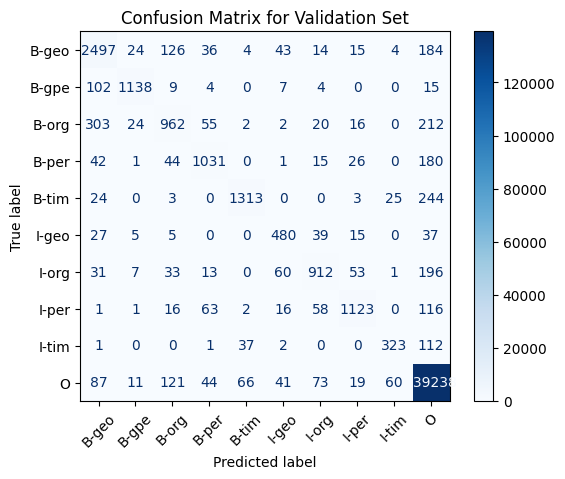

In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


y_pred_valid = model.predict(X_valid)
y_pred_valid_ids = np.argmax(y_pred_valid, axis=-1)
y_valid_flat = y_valid.flatten()
y_pred_valid_flat = y_pred_valid_ids.flatten()

cm_valid = confusion_matrix(y_valid_flat, y_pred_valid_flat, labels=list(label2id.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=list(label2id.keys()))
plt.figure(figsize=(10, 14))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Validation Set")
plt.show()

In [115]:
y_pred_valid.shape

(3808, 40, 10)

In [116]:
y_pred_valid.reshape(-1, y_pred_valid.shape[-1]).shape

(152320, 10)

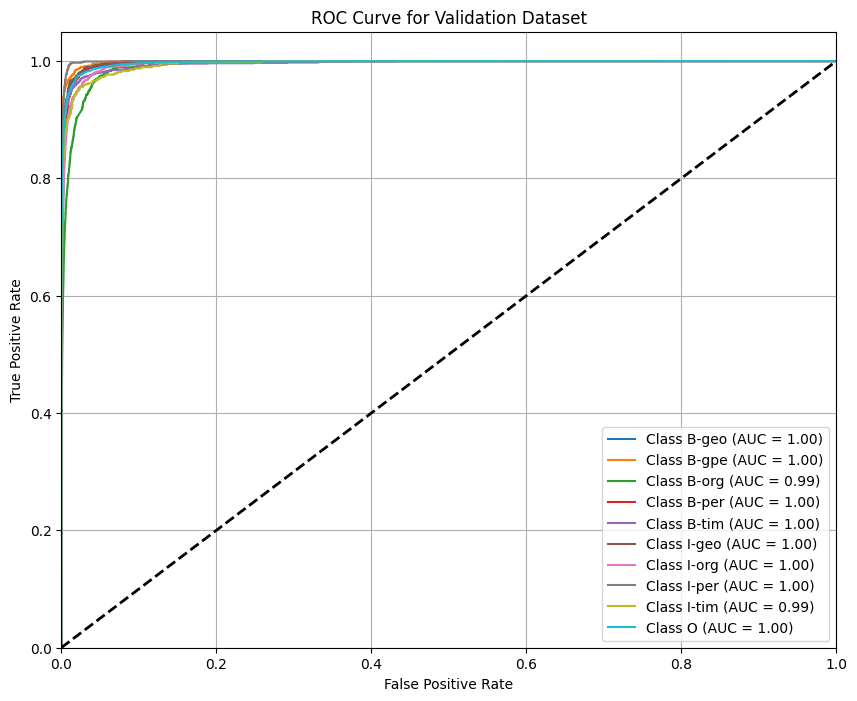

In [117]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Flatten the true labels and predicted probabilities for ROC computation
y_valid_flat = y_valid.flatten()
y_pred_valid_probs = y_pred_valid.reshape(-1, y_pred_valid.shape[-1])

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(label_size):
    fpr[i], tpr[i], _ = roc_curve((y_valid_flat == i).astype(int), y_pred_valid_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(label_size):
    plt.plot(fpr[i], tpr[i], label=f'Class {id2label[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Dataset')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [118]:
label2id

{'B-geo': 0,
 'B-gpe': 1,
 'B-org': 2,
 'B-per': 3,
 'B-tim': 4,
 'I-geo': 5,
 'I-org': 6,
 'I-per': 7,
 'I-tim': 8,
 'O': 9}

In [119]:
from seqeval.metrics import classification_report as seqeval_report

In [120]:
from sklearn.metrics import classification_report

# Predict
y_pred_test = model.predict(X_test)
y_pred_ids_test = np.argmax(y_pred_test, axis=-1)   #compare the distribution of the output of softmax for a token-word (10 scores comparison)
y_true_ids_test = y_test

# Flatten and filter padding
true_flat, pred_flat = [], []
for i in range(len(y_true_ids_test)):
    for true, pred in zip(y_true_ids_test[i], y_pred_ids_test[i]):
            true_flat.append(id2label[true])
            pred_flat.append(id2label[pred])

# Report
print(classification_report(true_flat, pred_flat, digits=4))


298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

       B-geo     0.8036    0.8564    0.8291      7491
       B-gpe     0.9411    0.9037    0.9220      3166
       B-org     0.7218    0.5719    0.6382      4006
       B-per     0.8241    0.7663    0.7941      3350
       B-tim     0.9009    0.8156    0.8562      3992
       I-geo     0.7437    0.7974    0.7696      1441
       I-org     0.8073    0.7057    0.7531      3259
       I-per     0.8663    0.8020    0.8329      3450
       I-tim     0.7883    0.6516    0.7135      1286
           O     0.9909    0.9962    0.9936    349359

    accuracy                         0.9781    380800
   macro avg     0.8388    0.7867    0.8102    380800
weighted avg     0.9773    0.9781    0.9775    380800



In [121]:
y_pred_test.shape[-1]

10

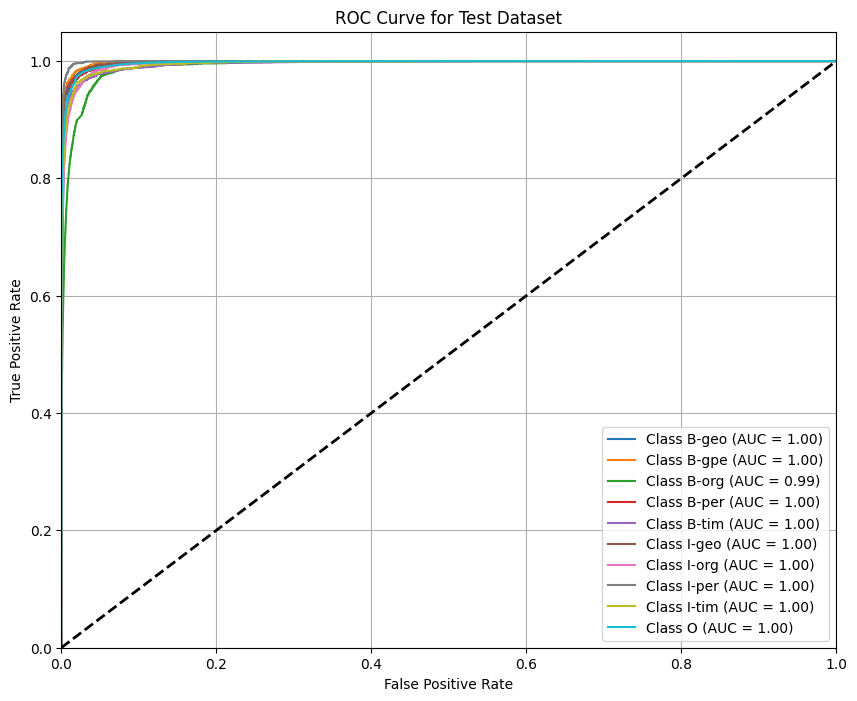

In [122]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

y_test_flat = y_test.flatten()
y_pred_test_probs = y_pred_test.reshape(-1, y_pred_test.shape[-1])

fpr = {}
tpr = {}
roc_auc = {}
for i in range(label_size):
    fpr[i], tpr[i], _ = roc_curve((y_test_flat == i).astype(int), y_pred_test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(label_size):
    plt.plot(fpr[i], tpr[i], label=f'Class {id2label[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.legend(loc='lower right')
plt.grid()
plt.show()

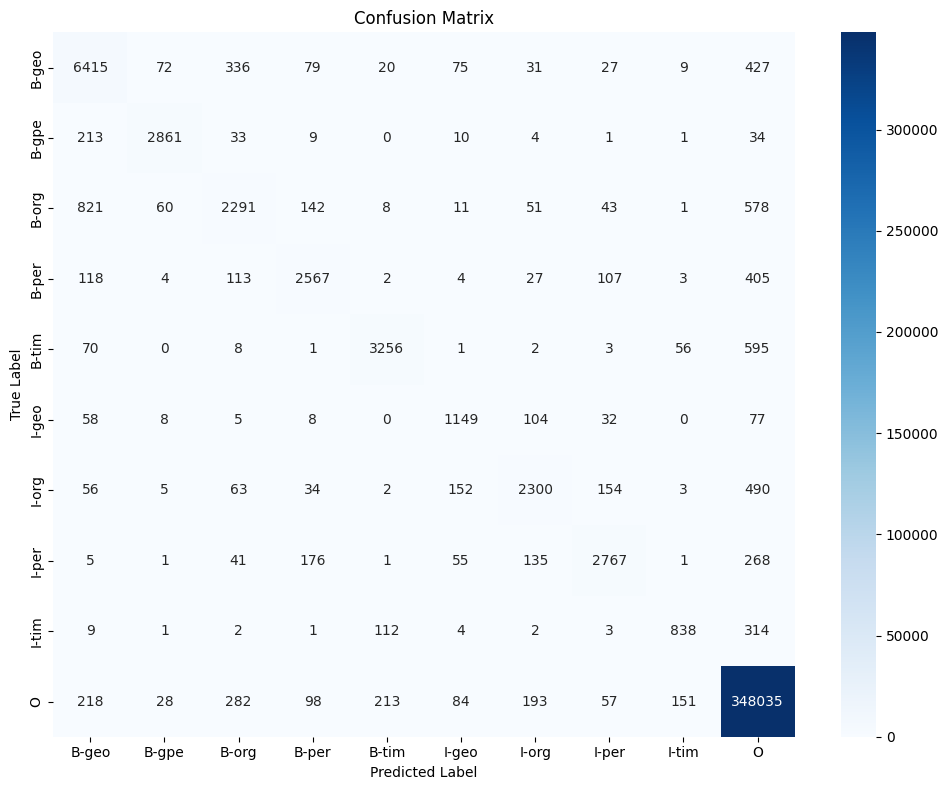

In [123]:

# Get all unique labels from your label map
all_labels = sorted(list(set(true_flat + pred_flat)))

cm = confusion_matrix(true_flat, pred_flat, labels=all_labels)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [124]:
y_true_ids_test.shape

(9520, 40)

In [125]:
def show_predictions(df, X, y_true_ids, y_pred_ids, index=0):
    print(f"\nSentence: {' '.join(df.loc[index, 'tokens'])}")
    print(f"{'Token':15} {'True':10} {'Predicted'}")
    print("-" * 40)
    for token, true, pred in zip(df.loc[index, 'tokens'], 
                                 [id2label[i] for i in y_true_ids[index]],
                                 [id2label[i] for i in y_pred_ids[index]]):
        print(f"{token:15} {true:10} {pred}")


In [126]:
show_predictions(test_df, X_test, y_true_ids_test, y_pred_ids_test, index=22)


Sentence: Pakistani officials say unidentified gunmen have killed three people , including a former government minister , in a semi-autonomous tribal region bordering Afghanistan .
Token           True       Predicted
----------------------------------------
Pakistani       B-gpe      B-gpe
officials       O          O
say             O          O
unidentified    O          O
gunmen          O          O
have            O          O
killed          O          O
three           O          O
people          O          O
,               O          O
including       O          O
a               O          O
former          O          O
government      O          O
minister        O          O
,               O          O
in              O          O
a               O          O
semi-autonomous O          O
tribal          O          O
region          O          O
bordering       O          O
Afghanistan     B-geo      B-gpe
.               O          O


## Test

In [127]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9766 - loss: 0.0831
Test Loss: 0.0740, Accuracy: 0.9781


In [128]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model('./models/ner_LSTM.keras')

In [129]:
def test_and_mask(sentence, model, word2id, label2id, id2label, MAX_LEN):
    tokens = sentence.strip().split()
    
    def encode(tokens, vocab, pad_len=MAX_LEN, fallback='<UNK>', pad_token='<PAD>'):
        fallback_id = vocab.get(fallback, list(vocab.values())[0])  
        pad_id = vocab.get(pad_token, list(vocab.values())[0])    
        ids = [vocab.get(tok, fallback_id) for tok in tokens]
        return ids[:pad_len] + [pad_id] * max(0, pad_len - len(ids))
    
    encoded_sentence = encode(tokens, word2id, pad_len=MAX_LEN)
    encoded_sentence = np.array([encoded_sentence])  
    
    # Predict using the model
    y_pred = model.predict(encoded_sentence)
    y_pred_ids = np.argmax(y_pred, axis=-1)[0] 
    
    # Decode the sentence and labels
    id2word = {v: k for k, v in word2id.items()}
    decoded_sentence = [id2word.get(word_id, '<UNK>') for word_id in encoded_sentence[0]]
    decoded_labels = [id2label[label_id] for label_id in y_pred_ids]
    
    # Mask the entities in the sentence
    masked_sentence = []
    for token, label in zip(decoded_sentence, decoded_labels):
        if token == '<PAD>':
            continue
        elif label == 'O':
            masked_sentence.append(token)
        else:
            masked_sentence.append(label)
    
    # Print the original and masked sentence
    print("Original Sentence:")
    print(" ".join(tokens))
    print("\nMasked Sentence:")
    print(" ".join(masked_sentence))

In [130]:
# Example usage
random_sentence = "Barack Obama was the president of the United States."
test_and_mask(random_sentence, model, word2id, label2id, id2label, MAX_LEN)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Original Sentence:
Barack Obama was the president of the United States.

Masked Sentence:
B-per I-per was the president of the B-geo I-org


In [131]:
# Example usage
random_sentence = "On June 15, 2023, Dr. Emily Carter, a renowned physicist from Princeton University, gave a keynote speech at the Global Climate Summit in Geneva, Switzerland. She emphasized the urgent need for international collaboration to combat climate change. Representatives from over 50 countries, including Canada, Brazil, and India, attended the event. Microsoft and Tesla announced a joint venture to develop carbon-neutral technologies. Meanwhile, UN Secretary-General António Guterres praised the summit's progress in aligning with the Paris Agreement. The summit also featured contributions from scientists at MIT and Oxford University. Elon Musk participated virtually from California, showcasing Tesla’s latest solar innovations. A follow-up summit is scheduled for November 2024 in Tokyo, Japan. Attendees shared insights via the official Twitter hashtag #GCS2023. The event concluded with a ceremonial tree planting sponsored by Green Earth Foundation."

In [132]:
batches = []
i = 1
MAX_LEN = len(random_sentence)
for i in range(0,MAX_LEN,40):
    chunk = random_sentence[i:40+i]
    string = ' '.join(chunk)
    batches.append(string)
    

In [133]:
masked_sentence_ = []
for sentence in batches:
    original_sequence,masked_sentence = test_and_mask(sentence, model,word2id, label2id,id2label,40)
    masked_sentence = ' '.join(masked_sentence)
    masked_sentence_.append(masked_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Original Sentence:
O n J u n e 1 5 , 2 0 2 3 , D r . E m i l y C a r t e r , a r e

Masked Sentence:
B-geo <UNK> <UNK> <UNK> <UNK> <UNK> B-tim I-tim , 2 <UNK> 2 3 , D <UNK> . <UNK> <UNK> I-per l <UNK> C a <UNK> <UNK> <UNK> I-per , a <UNK> <UNK>


TypeError: cannot unpack non-iterable NoneType object

In [244]:
random_sentence

['On',
 'June',
 '15,',
 '2023,',
 'Dr.',
 'Emily',
 'Carter,',
 'a',
 'renowned',
 'physicist',
 'from',
 'Princeton',
 'University,',
 'gave',
 'a',
 'keynote',
 'speech',
 'at',
 'the',
 'Global',
 'Climate',
 'Summit',
 'in',
 'Geneva,',
 'Switzerland.',
 'She',
 'emphasized',
 'the',
 'urgent',
 'need',
 'for',
 'international',
 'collaboration',
 'to',
 'combat',
 'climate',
 'change.',
 'Representatives',
 'from',
 'over',
 '50',
 'countries,',
 'including',
 'Canada,',
 'Brazil,',
 'and',
 'India,',
 'attended',
 'the',
 'event.',
 'Microsoft',
 'and',
 'Tesla',
 'announced',
 'a',
 'joint',
 'venture',
 'to',
 'develop',
 'carbon-neutral',
 'technologies.',
 'Meanwhile,',
 'UN',
 'Secretary-General',
 'António',
 'Guterres',
 'praised',
 'the',
 "summit's",
 'progress',
 'in',
 'aligning',
 'with',
 'the',
 'Paris',
 'Agreement.',
 'The',
 'summit',
 'also',
 'featured',
 'contributions',
 'from',
 'scientists',
 'at',
 'MIT',
 'and',
 'Oxford',
 'University.',
 'Elon',
 'Musk